# LifeSnaps Preprocessing Data v2.0
Preprocessem i millorem la neteja de dades previa, versió eliminant columnes = []

### Import de llibreries i warnings

In [264]:
# Exploració de dades
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessament de dades
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Model
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Analisis del model
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import joblib

In [265]:
import warnings
warnings.filterwarnings('ignore')

## Lectura del dataset cleaned i visualització dades ràpida

In [266]:
df = pd.read_csv('../data/df_cleaned.csv')
pd.set_option('display.max_columns', None)

display(df.head())
df.info()


,nightly_temperature,rmssd,spo2,full_sleep_breathing_rate,stress_score,daily_temperature_variation,calories,bpm,sedentary_minutes,resting_hr,minutesAsleep,minutesAwake,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,age,gender,bmi,TENSE/ANXIOUS,TIRED,bmi_tipo
0,34.137687,89.603,NaN,14.8,78.0,-1.788325,2351.59,71.701565,713.0,62.073070,445.0,76.0,93.0,NaN,0.987013,0.921642,NaN,8833.0,<30,MALE,18.4,NaN,NaN,Infrapes
1,33.794544,94.303,NaN,15.8,80.0,-2.462709,2332.08,70.579300,704.0,62.121476,460.0,88.0,94.0,NaN,NaN,0.947566,NaN,9727.0,<30,MALE,18.4,0.0,1.0,Infrapes
2,34.611011,119.212,NaN,14.6,84.0,-2.385801,2262.30,71.842573,710.0,62.263999,493.0,67.0,96.0,NaN,0.858974,NaN,NaN,8253.0,<30,MALE,18.4,0.0,0.0,Infrapes
3,34.408304,111.709,NaN,14.8,82.0,-2.124199,2325.10,71.725477,622.0,62.368900,540.0,87.0,93.0,NaN,NaN,NaN,NaN,9015.0,<30,MALE,18.4,0.0,0.0,Infrapes
4,34.178922,103.034,NaN,15.2,81.0,-2.396873,2586.76,74.401028,647.0,61.965409,493.0,68.0,94.0,0.910256,0.871795,NaN,NaN,12949.0,<30,MALE,18.4,0.0,0.0,Infrapes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7410 entries, 0 to 7409
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   nightly_temperature          3341 non-null   float64
 1   rmssd                        2445 non-null   float64
 2   spo2                         1270 non-null   float64
 3   full_sleep_breathing_rate    2416 non-null   float64
 4   stress_score                 1580 non-null   float64
 5   daily_temperature_variation  3304 non-null   float64
 6   calories                     6616 non-null   float64
 7   bpm                          4804 non-null   float64
 8   sedentary_minutes            3936 non-null   float64
 9   resting_hr                   4422 non-null   float64
 10  minutesAsleep                3547 non-null   float64
 11  minutesAwake                 3549 non-null   float64
 12  sleep_efficiency             3499 non-null   float64
 13  sleep_deep_ratio  

In [267]:
target_col = ['TIRED', 'TENSE/ANXIOUS']
categoric_col = ['age', 'gender', 'bmi_tipo']

numeric_col = df.drop(columns=categoric_col + target_col).columns.tolist()

print('Targets: ', target_col, '\n\nColumnes Categòriques: ', categoric_col, '\n\nColumnes numèriques: ', numeric_col)

Targets:  ['TIRED', 'TENSE/ANXIOUS'] 

Columnes Categòriques:  ['age', 'gender', 'bmi_tipo'] 

Columnes numèriques:  ['nightly_temperature', 'rmssd', 'spo2', 'full_sleep_breathing_rate', 'stress_score', 'daily_temperature_variation', 'calories', 'bpm', 'sedentary_minutes', 'resting_hr', 'minutesAsleep', 'minutesAwake', 'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps', 'bmi']


In [268]:
df[numeric_col].describe()

,nightly_temperature,rmssd,spo2,full_sleep_breathing_rate,stress_score,daily_temperature_variation,calories,bpm,sedentary_minutes,resting_hr,minutesAsleep,minutesAwake,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,bmi
count,3341.000000,2445.000000,1270.000000,2416.000000,1580.000000,3304.000000,6616.000000,4804.000000,3936.000000,4422.000000,3547.000000,3549.000000,3499.000000,1723.000000,1895.000000,1763.000000,1716.000000,4637.000000,6796.000000
mean,33.806424,40.512290,95.893228,15.321937,76.205063,-1.471843,2190.677251,80.250496,751.908537,66.268735,392.668452,56.469146,94.403830,0.770018,0.792210,0.831862,0.741248,8501.287039,23.080224
std,0.767878,20.966442,1.114339,2.698893,6.759862,0.967792,679.247479,9.503785,181.693918,7.234891,96.588530,22.105376,3.553334,0.173967,0.152462,0.127750,0.195661,5341.247629,3.445664
min,30.063649,8.327000,89.400000,9.800000,55.000000,-5.688866,1004.800000,43.500000,32.000000,44.122845,52.000000,0.000000,65.000000,0.061856,0.238806,0.265823,0.052083,102.000000,18.400000
25%,33.320326,25.703000,95.200000,13.400000,71.000000,-2.182988,1680.755000,74.692035,635.000000,61.637034,343.000000,43.000000,93.000000,0.668385,0.695652,0.759716,0.625000,4726.000000,20.000000
50%,33.889934,34.187000,95.900000,15.200000,76.000000,-1.415089,2073.600000,79.790362,731.000000,66.504308,401.000000,55.000000,95.000000,0.796875,0.820513,0.857678,0.785714,7600.000000,23.000000
75%,34.344228,49.089000,96.700000,17.200000,81.000000,-0.722098,2582.425000,85.165654,836.000000,71.432724,454.000000,70.000000,97.000000,0.908046,0.915254,0.932806,0.893617,11197.000000,25.000000
max,36.684793,122.089000,100.000000,29.800000,94.000000,3.393617,5415.540000,153.995380,1200.000000,86.000000,818.000000,197.000000,100.000000,1.000000,1.000000,1.000000,1.000000,32677.000000,30.000000


In [ ]:
plt.figure(figsize=(28, 100))
plotnumber = 1
for i in numeric_col:
    ax = plt.subplot(15, 4, plotnumber)
    sns.histplot(df[numeric_col][i], kde=True, ax=ax)
    plt.title(i, size=20)
    plotnumber += 1
plt.tight_layout()
plt.show()

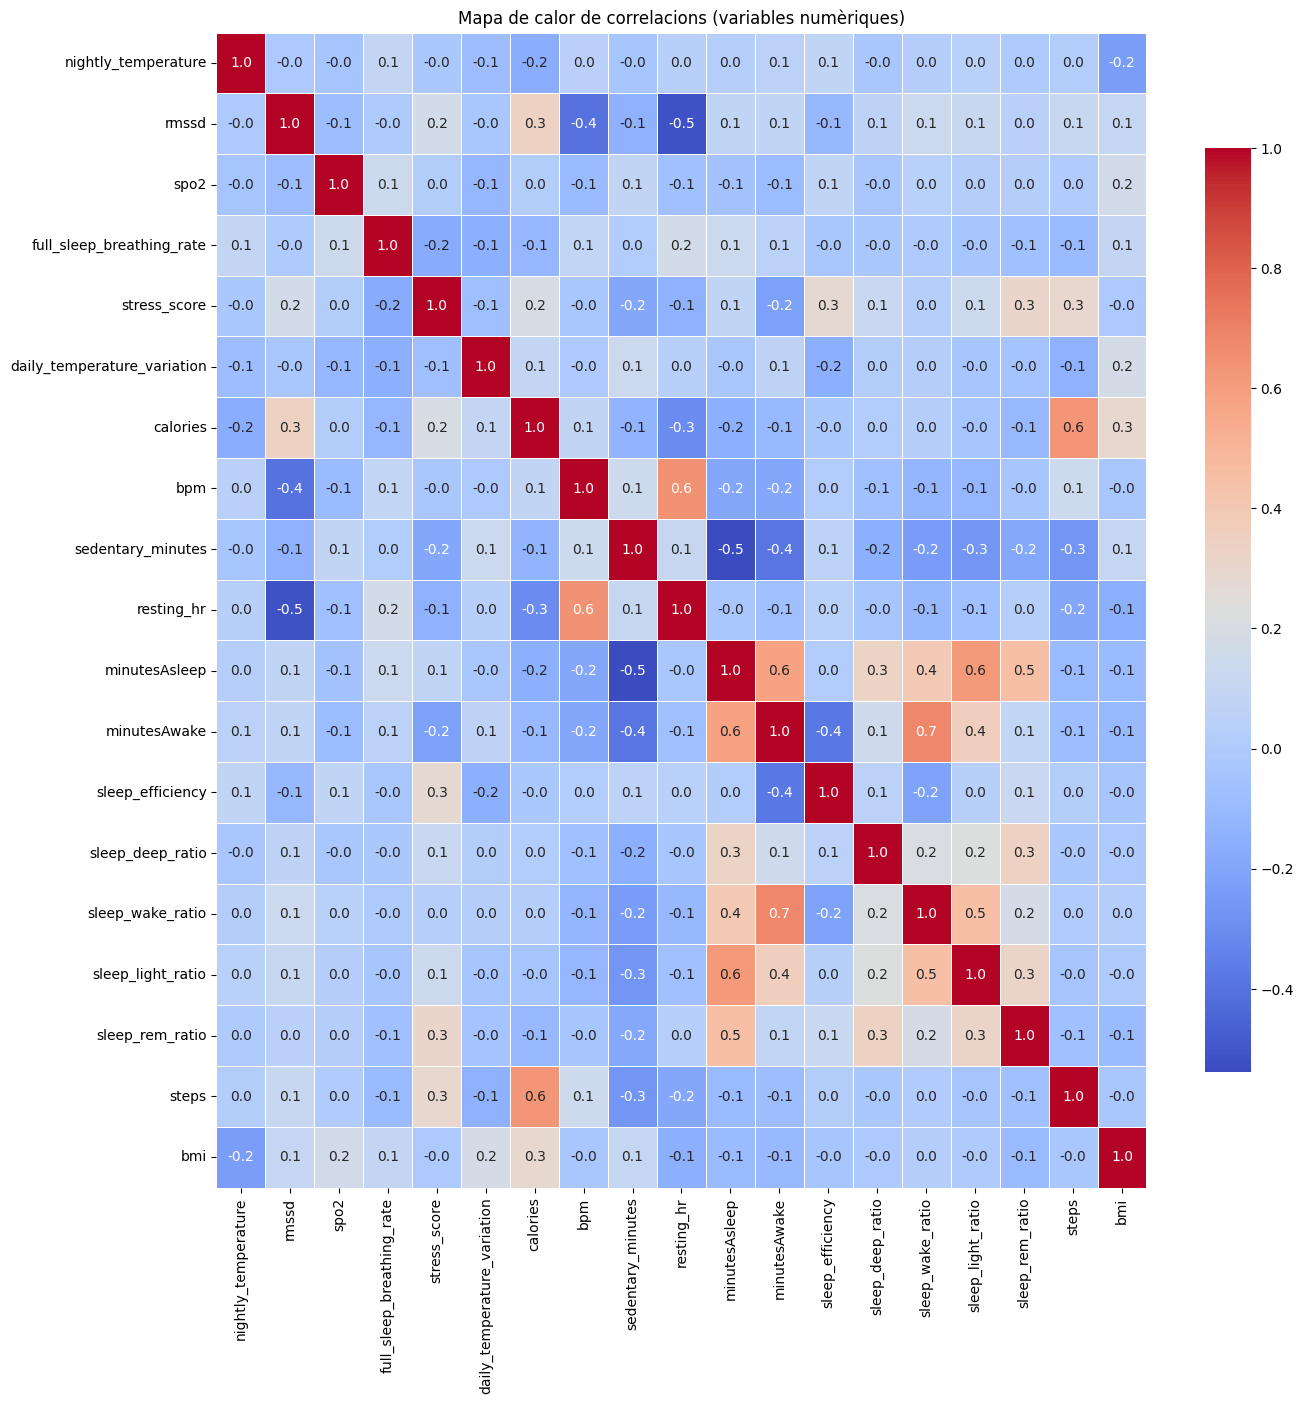

In [ ]:
## Numèric vs Numèric: matriu de correlació + scatter de parelles fortes
corr = df[numeric_col].corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr,annot=True, fmt=".1f", cmap="coolwarm", linewidths=.5, cbar_kws={"shrink": .8})
plt.title("Mapa de calor de correlacions (variables numèriques)")
plt.show()

## Preprocessament de dades

In [ ]:
# Eliminació de les columnes amb més valors absents
# Dades nules del dataset
# Percentatge de valors nuls
nul_percentage=df.isnull().sum()/df.shape[0]*100
print('Percentatge de valors nuls:', '\n')
print(nul_percentage)

Percentatge de valors nuls: 

nightly_temperature            54.912281
rmssd                          67.004049
spo2                           82.860999
full_sleep_breathing_rate      67.395412
stress_score                   78.677463
daily_temperature_variation    55.411606
calories                       10.715250
bpm                            35.168691
sedentary_minutes              46.882591
resting_hr                     40.323887
minutesAsleep                  52.132254
minutesAwake                   52.105263
sleep_efficiency               52.780027
sleep_deep_ratio               76.747638
sleep_wake_ratio               74.426451
sleep_light_ratio              76.207827
sleep_rem_ratio                76.842105
steps                          37.422402
age                             8.286100
gender                          4.993252
bmi                             8.286100
TENSE/ANXIOUS                  69.095816
TIRED                          69.095816
bmi_tipo                   

Eliminarem les columnes amb alt percentatge de valors absents que considerem necessaries eliminar i que podrien no aportar valor, ja que seguim tening sobre dimensioment segons l'analisi del PCA. Podriem eliminar fins a tenir 17-18 columnes, actualment en tenim 25.


In [ ]:
drop_cols = ['spo2', 'stress_score', 'daily_temperature_variation']
df=df.drop(columns=drop_cols)
numeric_col = df.drop(columns=categoric_col + target_col).columns.tolist()
df.shape

(7410, 21)

### Tractament de Valors Absents

Farem imputació simple sobre els valors absents per la mitjana a els valors numerics com heart rate i moda en els valors categorics

In [ ]:
X_full = df.drop(columns=target_col)
X_full.shape

(7410, 19)

### Visualització dels resultats

In [ ]:
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categoric_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),
                            ("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer([
    ("num", numeric_pipe, numeric_col),
    ("cat", categoric_pipe, categoric_col)
])



In [ ]:
# Visualitzem el dataset preprocessat
X_processed = preprocessor.fit_transform(X_full)

df_lbl=df.dropna(subset=target_col, how='all')
X_proc = preprocessor.transform(df_lbl.drop(columns=target_col))


feat_names = preprocessor.get_feature_names_out()

df_final = pd.concat([pd.DataFrame(X_proc, columns=feat_names, index=df_lbl.index), df_lbl[target_col]], axis=1)


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2290 entries, 1 to 7409
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   num__nightly_temperature        2290 non-null   float64
 1   num__rmssd                      2290 non-null   float64
 2   num__full_sleep_breathing_rate  2290 non-null   float64
 3   num__calories                   2290 non-null   float64
 4   num__bpm                        2290 non-null   float64
 5   num__sedentary_minutes          2290 non-null   float64
 6   num__resting_hr                 2290 non-null   float64
 7   num__minutesAsleep              2290 non-null   float64
 8   num__minutesAwake               2290 non-null   float64
 9   num__sleep_efficiency           2290 non-null   float64
 10  num__sleep_deep_ratio           2290 non-null   float64
 11  num__sleep_wake_ratio           2290 non-null   float64
 12  num__sleep_light_ratio          2290 no

In [ ]:
df_final.describe()

,num__nightly_temperature,num__rmssd,num__full_sleep_breathing_rate,num__calories,num__bpm,num__sedentary_minutes,num__resting_hr,num__minutesAsleep,num__minutesAwake,num__sleep_efficiency,num__sleep_deep_ratio,num__sleep_wake_ratio,num__sleep_light_ratio,num__sleep_rem_ratio,num__steps,num__bmi,cat__age_<30,cat__age_>=30,cat__gender_FEMALE,cat__gender_MALE,cat__bmi_tipo_Infrapes,cat__bmi_tipo_Normal,cat__bmi_tipo_Obes,cat__bmi_tipo_Sobrepes,TIRED,TENSE/ANXIOUS
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,0.058314,0.157663,-0.173516,0.411056,-0.166157,-0.134879,-0.175002,-0.017998,0.034437,-0.022964,-0.098560,-0.036390,-0.052566,-0.065730,0.141542,-0.023198,0.470742,0.529258,0.366376,0.633624,0.055895,0.652838,0.058079,0.233188,0.384279,0.220087
std,1.238780,1.248700,1.058042,1.063042,1.141519,1.139337,1.264384,1.259174,1.222026,1.323252,1.332753,1.258254,1.241622,1.271565,1.197377,0.889318,0.499252,0.499252,0.481919,0.481919,0.229769,0.476172,0.233943,0.422953,0.486531,0.414396
min,-7.325208,-2.241003,-3.528139,-1.752764,-4.141453,-5.346570,-3.762562,-5.153560,-3.637505,-12.083326,-8.447253,-6.372876,-6.931828,-7.536260,-1.895111,-1.416384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.383215,-0.168273,-0.544653,-0.320835,-0.803517,-0.746195,-0.866645,-0.552859,-0.568357,-0.292132,0.073792,0.092719,0.097098,0.107287,-0.673202,-0.931484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.072800,-0.168273,-0.025786,0.229050,-0.110538,-0.083620,0.025151,0.059572,-0.045949,0.114461,0.073792,0.092719,0.097098,0.107287,-0.132793,-0.022298,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.772674,0.071629,-0.025786,1.020419,0.396263,0.285313,0.558986,0.608519,0.607062,0.521053,0.073792,0.092719,0.097098,0.107287,0.703455,0.583826,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,5.476577,6.918901,9.443540,5.036436,9.216435,3.425013,3.092205,6.288443,6.092348,2.147425,2.474007,2.391982,2.346972,2.339885,5.696868,2.099137,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Entrenament del Model

In [ ]:
# Definim el cross validation i smote, aixi com els classifiers que utilitzarem
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
smote = SMOTE(random_state=42)

classifiers = {
    "MLP": (MLPClassifier(max_iter=1000, random_state=42), {
        "clf__hidden_layer_sizes": [(100,), (100, 50), (150,)],
        "clf__alpha": [1e-4, 1e-3, 1e-2]
    }),
    "SVM": (SVC(kernel="rbf", probability=True, random_state=42), {
        "clf__C": [1, 10, 100],
        "clf__gamma": ["scale", 0.01]
    }),
    "RandomForest": (RandomForestClassifier(class_weight="balanced",
                                            random_state=42), {
        "clf__n_estimators": [400, 800],
        "clf__max_depth": [None, 20]
    }),
    "GradientBoosting": (GradientBoostingClassifier(random_state=42), {
        "clf__n_estimators": [200, 400],
        "clf__learning_rate": [0.05, 0.1],
        "clf__max_depth": [3, 5]
    }),
}

In [ ]:
best_models = {}

for target in target_col:
    print(f"\n================= {target} =================")
    # Preparar X, y
    y = df_final[target].astype(int)
    X = df_final.drop(columns=target_col)

    # Train-test split con estratificación
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    best_recall = -1
    best_pipe   = None

    for name, (clf, grid) in classifiers.items():
        # Pipeline con SMOTE y clasificador
        pipe = ImbPipeline([
            ("sm", smote),
            ("clf", clf)
        ])
        # GridSearch optimizando recall
        search = GridSearchCV(
            pipe,
            param_grid=grid,
            scoring="recall",
            cv=cv,
            n_jobs=-1,
            verbose=0
        )
        search.fit(X_train, y_train)

        # Evaluación
        y_pred = search.predict(X_test)
        rec = recall_score(y_test, y_pred)
        print(f"{name:15s}  recall={rec:.3f}  | best params: {search.best_params_}")

        if rec > best_recall:
            best_recall = rec
            best_pipe   = search.best_estimator_

    # Informe del mejor modelo
    print("\nClassification report del mejor model:")
    y_best_pred = best_pipe.predict(X_test)
    print(classification_report(y_test, y_best_pred))

    # Visualización de la matriz de confusión
    cm = confusion_matrix(y_test, y_best_pred)
    classes = np.unique(y_test)
    fig, ax = plt.subplots()

    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(classes)),
        yticks=np.arange(len(classes)),
        xticklabels=classes,
        yticklabels=classes,
        xlabel="Predicted label",
        ylabel="True label",
        title=f"Matriz de confusión — {target}"
    )
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.show()

    # Guarda modelo
    safe_name = target.replace("/", "_")  # para nombres de archivo
    joblib.dump(best_pipe, f"../models/best_{safe_name}.joblib")
    best_models[target] = (best_pipe, best_recall)

# Resumen final
print("\n===== TOP models (segons recall) =====")
for tgt, (model, rec) in best_models.items():
    print(f"{tgt:15s} -> {type(model.named_steps['clf']).__name__}  (recall={rec:.3f})")


================= TIRED =================
MLP              recall=0.500  | best params: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,)}
SVM              recall=0.517  | best params: {'clf__C': 1, 'clf__gamma': 'scale'}


KeyboardInterrupt: 